<a href="https://colab.research.google.com/github/Abby263/TSAI_EVA_8/blob/main/Session_5/Normalization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import matplotlib.pyplot as plt

from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR,OneCycleLR

In [ ]:
import torch.nn.functional as F

dropout_value = 0.1
num_groups = 2

# Layer Normalization
# Source : https://pytorch.org/docs/stable/generated/torch.nn.LayerNorm.html

class Net(nn.Module):
    def __init__(self, norm_type='batch'):
        super(Net, self).__init__()

        self.norm_type = norm_type

        self.conv_block1 = self.conv_block(in_channels=1, out_channels=8, kernel_size=(3, 3), padding=0, bias=False, output_size=26)  # (28, 28, 1) --> (26, 26, 8)
        self.conv_block2 = self.conv_block(in_channels=8, out_channels=16, kernel_size=(3, 3), padding=0, bias=False, output_size=24) # (26, 26, 8) --> (24, 24, 16)

        # TRANSITION BLOCK 1
        self.transitionblock = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(1, 1), padding=0, bias=False)) # (24, 24, 16) --> (24, 24, 10)
        self.pool1 = nn.MaxPool2d(2, 2) # (24, 24, 10) --> (12, 12, 10)

        self.conv_block3 = self.conv_block(in_channels=10, out_channels=8, kernel_size=(3, 3), padding=0, bias=False, output_size=10) # (12, 12, 10) --> (10, 10, 8)
        self.conv_block4 = self.conv_block(in_channels=8, out_channels=8, kernel_size=(3, 3), padding=0, bias=False, output_size=8) # (10, 10, 8) --> (8, 8, 8)
        self.conv_block5 = self.conv_block(in_channels=8, out_channels=8, kernel_size=(3, 3), padding=0, bias=False, output_size=6) # (8, 8, 8) --> (6, 6, 8)
        self.conv_block6 = self.conv_block(in_channels=8, out_channels=8, kernel_size=(3, 3), padding=1, bias=False, output_size=6) # (6, 6, 8) --> (6, 6, 8)
        
        # OUTPUT BLOCK
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=6)) #  (6, 6, 8) --> (1, 1, 8)

        self.convblockoutput = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=10, kernel_size=(1, 1), padding=0, bias=False)) # (1, 1, 8) --> (1, 1, 10) 

        self.dropout = nn.Dropout(dropout_value)

    def conv_block(self, in_channels, out_channels, kernel_size, padding, bias, output_size=None):
      
      if self.norm_type == 'batch':
        return nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, padding=padding, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(out_channels),
            nn.Dropout(dropout_value)
        ) 
      elif self.norm_type == 'layer':
        return nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, padding=padding, bias=False),
            nn.ReLU(),
            nn.LayerNorm([out_channels, output_size, output_size]),
            nn.Dropout(dropout_value)
        )
      elif self.norm_type == 'group':
        return nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, padding=padding, bias=False),
            nn.ReLU(),
            nn.GroupNorm(num_groups, out_channels),
            nn.Dropout(dropout_value)
        )

    def forward(self, x):
        x = self.conv_block1(x)
        x = self.conv_block2(x)
        x = self.transitionblock(x)
        x = self.pool1(x)

        x = self.conv_block3(x)
        x = self.conv_block4(x)
        x = self.conv_block5(x)
        x = self.conv_block6(x)
       
        x = self.gap(x)        
        x = self.convblockoutput(x)

        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)
        

In [ ]:
# !pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = Net(norm_type='group').to(device)
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              72
              ReLU-2            [-1, 8, 26, 26]               0
         GroupNorm-3            [-1, 8, 26, 26]              16
           Dropout-4            [-1, 8, 26, 26]               0
            Conv2d-5           [-1, 16, 24, 24]           1,152
              ReLU-6           [-1, 16, 24, 24]               0
         GroupNorm-7           [-1, 16, 24, 24]              32
           Dropout-8           [-1, 16, 24, 24]               0
            Conv2d-9           [-1, 10, 24, 24]             160
        MaxPool2d-10           [-1, 10, 12, 12]               0
           Conv2d-11            [-1, 8, 10, 10]             720
             ReLU-12            [-1, 8, 10, 10]               0
        GroupNorm-13            [-1, 8, 10, 10]              16
          Dropout-14            [-1, 8,

In [ ]:
torch.manual_seed(1)
batch_size = 128

kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                    transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])),
    batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])),
    batch_size=batch_size, shuffle=True, **kwargs)


In [ ]:
from tqdm import tqdm

lambda_l1 = 0.01
lambda_orth = 0.01 

def l1_regularizer(model, lambda_l1=0.01):
    lossl1 = 0
    for model_param_name, model_param_value in model.named_parameters():
            if model_param_name.endswith('weight'):
                lossl1 += lambda_l1 * model_param_value.abs().sum()
    return lossl1

def orth_regularizer(model, lambda_orth=0.01):
    lossorth = 0
    for model_param_name, model_param_value in model.named_parameters():
            if model_param_name.endswith('weight'):
                param_flat = model_param_value.view(model_param_value.shape[0], -1)
                sym = torch.mm(param_flat, torch.t(param_flat))
                sym -= torch.eye(param_flat.shape[0])
                lossorth += lambda_orth * sym.sum()
    return lossorth

def train(model, device, train_loader, optimizer, epoch):
    model.train()
    pbar = tqdm(train_loader)
    for batch_idx, (data, target) in enumerate(pbar):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        pbar.set_description(desc= f'loss={loss.item()} batch_id={batch_idx}')

def train_l1_loss(model, device, train_loader, optimizer, epoch):
    model.train()
    pbar = tqdm(train_loader)
    for batch_idx, (data, target) in enumerate(pbar):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target) + l1_regularizer(model, lambda_l1=lambda_l1)
        loss.backward()
        optimizer.step()
        pbar.set_description(desc= f'loss={loss.item()} batch_id={batch_idx}')


def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

In [ ]:
from torch.optim.lr_scheduler import StepLR

model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = StepLR(optimizer, step_size=6, gamma=0.1)

for epoch in range(1, 20):
  print('Epoch :', epoch)
  train(model, device, train_loader, optimizer, epoch)
  test(model, device, test_loader)

Epoch : 1


loss=0.2858213484287262 batch_id=468: 100%|██████████| 469/469 [00:53<00:00,  8.72it/s]



Test set: Average loss: 0.1378, Accuracy: 9641/10000 (96.41%)

Epoch : 2


loss=0.10322775691747665 batch_id=468: 100%|██████████| 469/469 [00:50<00:00,  9.34it/s]



Test set: Average loss: 0.0861, Accuracy: 9754/10000 (97.54%)

Epoch : 3


loss=0.06175832077860832 batch_id=468: 100%|██████████| 469/469 [00:51<00:00,  9.04it/s]



Test set: Average loss: 0.0804, Accuracy: 9749/10000 (97.49%)

Epoch : 4


loss=0.025359751656651497 batch_id=468: 100%|██████████| 469/469 [00:58<00:00,  7.96it/s]



Test set: Average loss: 0.0685, Accuracy: 9783/10000 (97.83%)

Epoch : 5


loss=0.12874558568000793 batch_id=468: 100%|██████████| 469/469 [00:50<00:00,  9.37it/s]



Test set: Average loss: 0.0715, Accuracy: 9780/10000 (97.80%)

Epoch : 6


loss=0.15431112051010132 batch_id=468: 100%|██████████| 469/469 [00:49<00:00,  9.44it/s]



Test set: Average loss: 0.0493, Accuracy: 9843/10000 (98.43%)

Epoch : 7


loss=0.08965524286031723 batch_id=468: 100%|██████████| 469/469 [00:49<00:00,  9.52it/s]



Test set: Average loss: 0.0480, Accuracy: 9846/10000 (98.46%)

Epoch : 8


loss=0.04730834439396858 batch_id=468: 100%|██████████| 469/469 [00:49<00:00,  9.49it/s]



Test set: Average loss: 0.0462, Accuracy: 9857/10000 (98.57%)

Epoch : 9


loss=0.08937542885541916 batch_id=468: 100%|██████████| 469/469 [00:49<00:00,  9.53it/s]



Test set: Average loss: 0.0401, Accuracy: 9879/10000 (98.79%)

Epoch : 10


loss=0.05042794719338417 batch_id=468: 100%|██████████| 469/469 [00:48<00:00,  9.62it/s]



Test set: Average loss: 0.0425, Accuracy: 9876/10000 (98.76%)

Epoch : 11


loss=0.055991753935813904 batch_id=468: 100%|██████████| 469/469 [00:49<00:00,  9.48it/s]



Test set: Average loss: 0.0397, Accuracy: 9878/10000 (98.78%)

Epoch : 12


loss=0.11887814849615097 batch_id=372:  80%|███████▉  | 373/469 [00:44<00:11,  8.37it/s]


KeyboardInterrupt: ignored

In [ ]:
def wrong_predictions(test_loader,model,device):
  wrong_images=[]
  wrong_label=[]
  correct_label=[]
  with torch.no_grad():
    for data, target in test_loader:
      data, target = data.to(device), target.to(device)
      output = model(data)        
      pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability

      wrong_pred = (pred.eq(target.view_as(pred)) == False)
      wrong_images.append(data[wrong_pred])
      wrong_label.append(pred[wrong_pred])
      correct_label.append(target.view_as(pred)[wrong_pred])  
      
      wrong_predictions = list(zip(torch.cat(wrong_images),torch.cat(wrong_label),torch.cat(correct_label)))    
    print(f'Total wrong predictions are {len(wrong_predictions)}')
      
      
    fig = plt.figure(figsize=(8,10))
    fig.tight_layout()
    for i, (img, pred, correct) in enumerate(wrong_predictions[:10]):
          img, pred, target = img.cpu().numpy(), pred.cpu(), correct.cpu()
          ax = fig.add_subplot(5, 2, i+1)
          ax.axis('off')
          ax.set_title(f'\nactual {target.item()}\npredicted {pred.item()}',fontsize=10)  
          ax.imshow(img.squeeze(), cmap='gray_r')  
          
    plt.show()
      
  return 

Total wrong predictions are 189


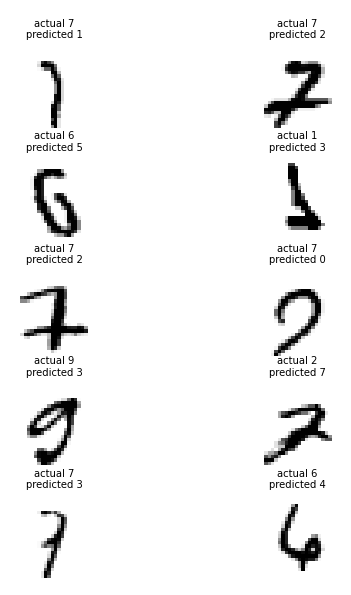

In [ ]:
wrong_predictions(test_loader,model,device)